In [10]:
from glob import glob
import matplotlib.pylab as plt

import pydicom as dicom

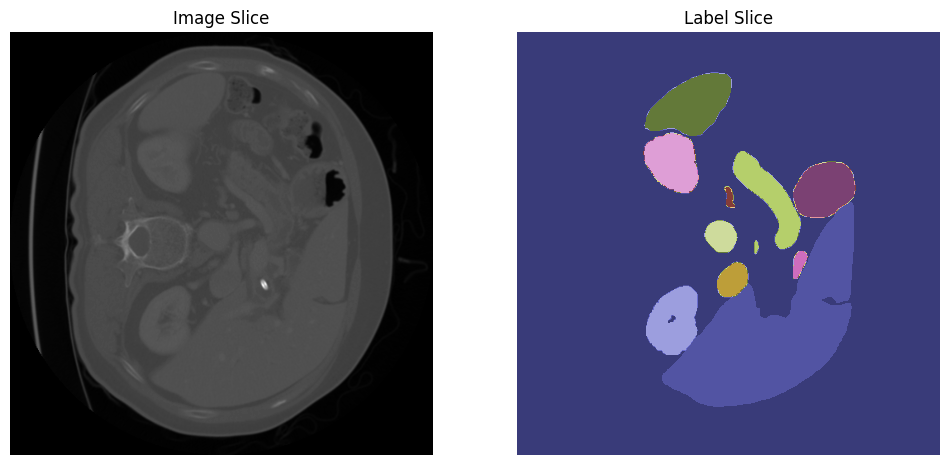

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the first image and label files
image_path = '/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/images/FLARE22_Tr_0001_0000.nii'
label_path = '/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/labels/FLARE22_Tr_0001.nii/FLARE22_Tr_0001.nii'

# Read the NIfTI files
image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

# Get the image and label data as numpy arrays
image_data = image_nii.get_fdata()
label_data = label_nii.get_fdata()

# Plot a slice of the image and its corresponding label
slice_index = image_data.shape[2] 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display image slice
ax[0].imshow(image_data[:, :, slice_index], cmap='gray')
ax[0].set_title('Image Slice')
ax[0].axis('off')

# Display label slice
ax[1].imshow(label_data[:, :, slice_index], cmap='tab20b')
ax[1].set_title('Label Slice')
ax[1].axis('off')

plt.show()

In [12]:
# Install necessary libraries
!pip install torch torchvision nibabel scikit-image matplotlib tqdm

In [19]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [20]:
torch.cuda.empty_cache()


# **Importing Libraries**

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np


# **VNet**

In [23]:

class VNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(VNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.enc1 = self.conv_block(n_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)
        self.enc5 = self.conv_block(128, 256)

        self.pool = nn.MaxPool3d(2)

        self.dec5 = self.conv_block(256, 128)
        self.dec4 = self.conv_block(128, 64)
        self.dec3 = self.conv_block(64, 32)
        self.dec2 = self.conv_block(32, 16)
        self.dec1 = self.conv_block(16, 16)

        self.upconv5 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.upconv4 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.upconv3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.upconv2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.upconv1 = nn.ConvTranspose3d(16, 16, 2, stride=2)

        self.final_conv = nn.Conv3d(16, n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        dec5 = self.upconv5(enc5)
        dec5 = torch.cat([dec5, enc4], dim=1)
        dec5 = self.dec5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat([dec4, enc3], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(dec1)

        out = self.final_conv(dec1)
        return out


# **Accessing the Data**

In [24]:

class CTDataset(Dataset):
    def __init__(self, image_paths, label_paths, target_size=(256, 256, 128), transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = nib.load(self.image_paths[idx]).get_fdata()
        label = nib.load(self.label_paths[idx]).get_fdata()

        image = self.resize_volume(image, self.target_size)
        label = self.resize_volume(label, self.target_size)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

    def resize_volume(self, volume, target_size):
        volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        volume = F.interpolate(volume, size=target_size, mode='trilinear', align_corners=False)
        return volume.squeeze(0).squeeze(0).numpy()

# Paths to your images and labels
image_paths = [f'/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/images/FLARE22_Tr_{str(i).zfill(4)}_0000.nii' for i in range(1, 51)]
label_paths = [f'/kaggle/input/ct-abdomen-organ-segmentation-dataset/FLARE22Train/labels/FLARE22_Tr_{str(i).zfill(4)}.nii/FLARE22_Tr_{str(i).zfill(4)}.nii' for i in range(1, 51)]


# **Adjusting the Hyperparameters**

In [25]:

# Hyperparameters
batch_size = 1
learning_rate = 1e-4
num_epochs = 50

# Dataset and DataLoader
train_dataset = CTDataset(image_paths, label_paths, target_size=(256, 256, 128))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


# **Model Training**

In [21]:

# Model, Loss, and Optimizer
model = VNet(n_channels=1, n_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For mixed precision training
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

# Training Loop with mixed precision
try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')

    print("Training completed successfully!")

    # Save model
    torch.save(model.state_dict(), 'vnet_model.pth')
    print("Model saved successfully!")

except RuntimeError as e:
    print(f"RuntimeError occurred: {e}")
    print("CUDA memory summary:")
    print(torch.cuda.memory_summary(device=device))

except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    print("Script execution completed.")

Using device: cuda:0
RuntimeError occurred: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 566.12 MiB is free. Process 2903 has 14.19 GiB memory in use. Of the allocated memory 13.46 GiB is allocated by PyTorch, and 464.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
CUDA memory summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 37           |        cudaMalloc retries: 40        |
|===========================================================================|
|        Metric         | Cur